## Import Libraries

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorboard
import tensorflow as tf
import matplotlib.pyplot as plt


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Define Functions

### Function For Making Weights Martix

In [68]:
def create_weights(vectors_ref:pd.DataFrame , word_dict:dict):
    rows = len(word_dict) +1
    columns = len(vectors_ref.columns)
    shape = (rows , columns)
    weights = np.zeros(shape=shape)
    inx = list(set(vectors_ref.index) & set(list(word_dict.values())))
    vectors_ref = vectors_ref.loc[inx]
    for key in word_dict.keys():
        try:
            weights[key] = vectors_ref.loc[word_dict[key]]
        except:
            pass
    return weights


### Define Model Structure

In [ ]:
def create_model(maxlen , weights , input_dim , output_dim = 100):
    model = Sequential()
    model.add(layers.Input((maxlen,)))
    model.add(layers.Embedding(input_dim= input_dim , output_dim=100 , input_length= maxlen , weights = [weights],trainable = False))
    model.add(layers.Conv1D(128,5)) 
    model.add(layers.MaxPool1D(pool_size=2))
    model.add(layers.LSTM(32, activation='relu'))
    model.add(layers.Dense(1 ,activation ="sigmoid"))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-2,decay_rate=0.9999,decay_steps=1000)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
                metrics=['accuracy'])

    return model


## Read Data

In [54]:
df = pd.read_csv("processed_regex_no_stem.csv")
glove = pd.read_csv("glove.6B.100d.txt",header=None , delimiter=" " ,quoting=csv.QUOTE_NONE, encoding='utf-8')
glove.set_index(0 , drop= True,inplace=True)

## Split Data

In [55]:
X_data,  y_data = df["processed"] , df["labels"]

In [56]:
X, X_validation, y, y_validation = train_test_split(X_data, y_data, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Process Data

In [57]:
tokenizer = Tokenizer(oov_token = "<oov>", lower= True)
tokenizer.fit_on_texts(X_train)

In [58]:
input_dim = len(tokenizer.index_word) +1
longest_sentence_length = X_train.apply(lambda x : len(x.split())).max()
X_train.apply(lambda x : len(x.split())).describe()

count    514.000000
mean     191.313230
std      119.524566
min        8.000000
25%      111.250000
50%      166.000000
75%      232.000000
max      861.000000
Name: processed, dtype: float64

In [62]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_validation = tokenizer.texts_to_sequences(X_validation)

In [63]:
X_train = pad_sequences(X_train, maxlen= maxlen , padding= "post")
X_test = pad_sequences(X_test, maxlen= maxlen , padding= "post")
X_validation = pad_sequences(X_validation, maxlen= maxlen , padding= "post")

## Make Weights Matrix From glove 

In [64]:
weights = create_weights(glove , tokenizer.index_word)

In [65]:
weights.shape

(8019, 100)

## Setting Parameters

In [ ]:
maxlen = 200
log_dir = "logs_hybrid_no_stem\\" + datetime.now().strftime("%d-%m-%Y_%H%M%S")
checkpoint_path = "checkpoints_hybrid_model_no_stem/cp.ckpt"
model_path = "model_hybrid_no_stem"
EPOCHS = 10
BATCH_SIZE = 32

## Create A Model

In [69]:
model = create_model(maxlen=maxlen , input_dim= input_dim , weights=weights )
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 100)          801900    
                                                                 
 conv1d_4 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 98, 128)          0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 886,669
Trainable params: 84,769
Non-trainable params: 801,900
___________________________________________

## Callbacks

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
      monitor="accuracy",
      min_delta=1e-3,
      patience=5,
      verbose=1,
      restore_best_weights=True,
    )


check_point_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Train Model

In [70]:
history = model.fit(x = X_train , y = y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_cb,check_point_cb,tensorboard_callback])

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 726831.4375 - accuracy: 0.5214
Epoch 00001: saving model to hybrid_model_weights\cp.ckpt
65/65 [==============================] - 9s 96ms/step - loss: 726831.4375 - accuracy: 0.5214 - val_loss: 10.7829 - val_accuracy: 0.5426
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 434.3632 - accuracy: 0.5292
Epoch 00002: saving model to hybrid_model_weights\cp.ckpt
65/65 [==============================] - 6s 90ms/step - loss: 434.3632 - accuracy: 0.5292 - val_loss: 6.9808 - val_accuracy: 0.5581
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 8.4274 - accuracy: 0.4747
Epoch 00003: saving model to hybrid_model_weights\cp.ckpt
65/65 [==============================] - 6s 90ms/step - loss: 8.4274 - accuracy: 0.4747 - val_loss: 19.1899 - val_accuracy: 0.4574
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 37.6591 - accuracy: 0.4981
Epoch 00004: saving model to hybrid_model_w

## Model History

In [ ]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

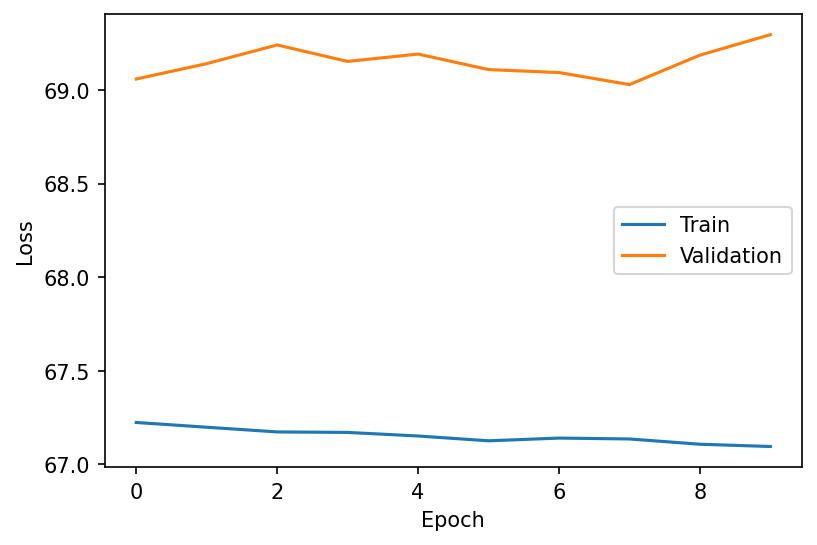

In [ ]:
plt.figure(dpi=150 )
plt.plot([100*loss for loss in train_loss] ,label = "Train")
plt.plot([100*loss for loss in val_loss] , label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

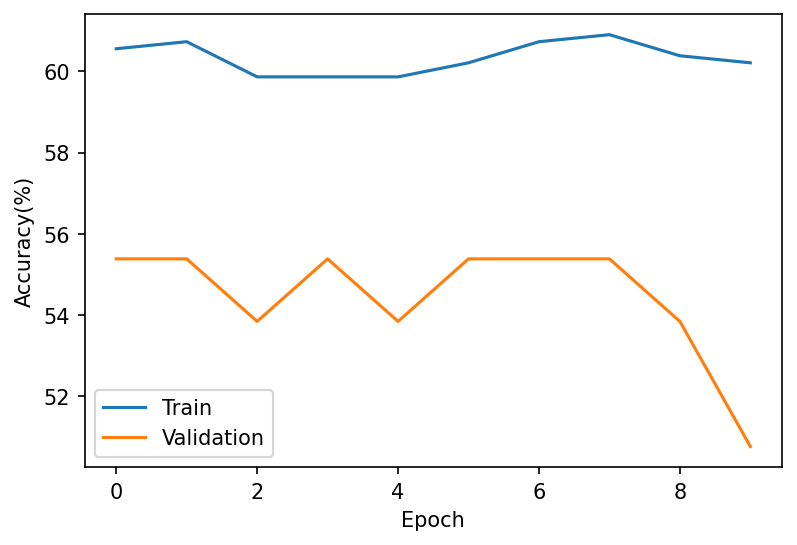

In [ ]:
plt.figure(dpi=150 )
plt.plot([100*acc for acc in train_accuracy] ,label = "Train")
plt.plot([100*acc for acc in val_accuracy] , label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.legend()

## Save Model

In [ ]:
model.save(model_path)

INFO:tensorflow:Assets written to: model\assets


# Evaluation on Test Data

### Load Model

In [ ]:
model = tf.keras.models.load_model(model_path)

### Predict on Test Data

In [ ]:
Y_pred_prob = model.predict(X_validation)
Y_pred = np.apply_along_axis(lambda x : 1 if x>0.5 else 0,1,Y_pred_prob  )

### Evaluation Metrics

In [ ]:
confusion_matrix(y_validation,Y_pred )

array([[18, 49],
       [20, 74]], dtype=int64)

In [ ]:
print(classification_report(y_validation,Y_pred ))

              precision    recall  f1-score   support

           0       0.47      0.27      0.34        67
           1       0.60      0.79      0.68        94

    accuracy                           0.57       161
   macro avg       0.54      0.53      0.51       161
weighted avg       0.55      0.57      0.54       161

